# Лабораторная работа №4

## Номер VI.9.32

### Импорт библиотек

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import bisect

### Заполнение таблицы значений

In [13]:
years = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
values = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906])

## Метод Ньютона

### Описание функции для расчёта разделённой разности

In [14]:
def sep_diff(years, values):
	size = np.shape(years)[0]
	diffs = np.zeros([size, size])
	for i in range(0, size):
		diffs[i, 0] = values[i]
	for j in range(1, size):
		for i in range(j,size):
			diffs[i, j] = (diffs[i, j-1] - diffs[i-1,j-1])/(years[i]-years[i-j])
	col = np.zeros([size])
	for i in range(0, size):
		col[i] = diffs[i, i]
	return col

### Вычисление полинома Ньютона

In [15]:
def interp_Newton(years, values, point):
	col_diff = sep_diff(years, values)
	size = np.shape(col_diff)[0]
	val = col_diff[0]
	scope = 1
	for i in range(size-1):
		scope = (point - years[i])*scope
		val = val + col_diff[i+1]*scope
	return val

### Построение графика полинома Ньютона

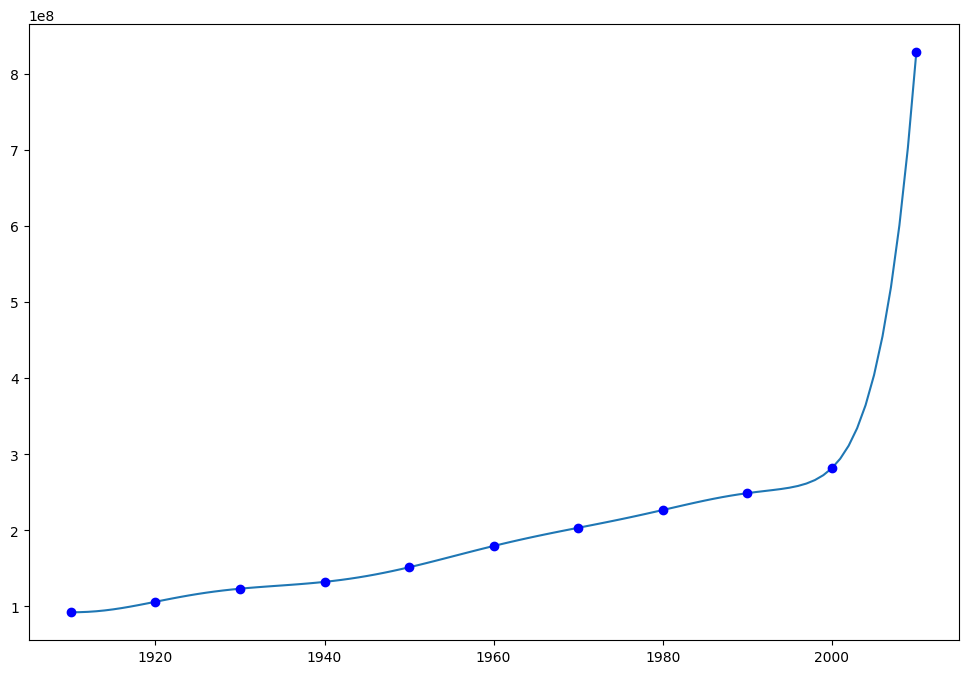

In [16]:
x = np.arange(years[0], 2010+1, 1)
y = interp_Newton(years, values, x)

plt.figure(figsize=(12,8))
plt.plot(x, y)
plt.plot(np.append(years, 2010), np.append(values, interp_Newton(years, values, 2010)), 'bo')
plt.show()

### Определение значения численности населения в 2010-ом году

In [17]:
val_2010 = interp_Newton(years, values, 2010)
print("Экстраполированное значение численности населения ", int(val_2010))
val_2010_real = 308745538
print("Погрешность данной величины равна: ", int(100*(val_2010-val_2010_real)/val_2010_real), "%")

Экстраполированное значение численности населения  827906509
Погрешность данной величины равна:  168 %


## Сплайн-аппроксимация

### Создание трёхдиагональной матрицы

In [18]:
def compute_diffs(x):
    return np.array([x[i+1] - x[i] for i in range(len(x) - 1)])

def create_tridiagonalmatrix(n, h):
    A = np.array([h[i] / (h[i] + h[i + 1]) for i in range(n - 2)] + [0])
    B = np.array([2] * n)
    C = np.array([0] + [h[i + 1] / (h[i] + h[i + 1]) for i in range(n - 2)])
    return A, B, C

def create_target(n, h, y):
    return np.array([0] + [6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]) / (h[i] + h[i-1]) for i in range(1, n - 1)] + [0])

### Решение трёхдиагональной системы

In [19]:
def solve_tridiagonalsystem(A, B, C, D):
    c_p = np.append(C, 0)
    d_p = np.zeros(np.shape(B)[0])
    X = np.zeros(np.shape(B)[0])

    c_p[0] = C[0] / B[0]
    d_p[0] = D[0] / B[0]
    for i in range(1, np.shape(B)[0]):
        c_p[i] = c_p[i] / (B[i] - c_p[i - 1] * A[i - 1])
        d_p[i] = (D[i] - d_p[i - 1] * A[i - 1]) / (B[i] - c_p[i - 1] * A[i - 1])

    X[-1] = d_p[-1]
    for i in range(np.shape(B)[0] - 2, -1, -1):
        X[i] = d_p[i] - c_p[i] * X[i + 1]

    return X

### Вычисление сплайна

In [20]:
def compute_spline(x, y):
    n = len(x)
    h = compute_diffs(x)
    A, B, C = create_tridiagonalmatrix(n, h)
    D = create_target(n, h, y)

    M = solve_tridiagonalsystem(A, B, C, D)

    coefficients = np.array([[(M[i+1]-M[i])*h[i]*h[i]/6, M[i]*h[i]*h[i]/2, (y[i+1] - y[i] - (M[i+1]+2*M[i])*h[i]*h[i]/6), y[i]] for i in range(n-1)])

    def spline(val):
        idx = min(bisect.bisect(x, val)-1, n-2)
        z = (val - x[idx]) / h[idx]
        C = coefficients[idx]
        return (((C[0] * z) + C[1]) * z + C[2]) * z + C[3]

    return spline

### Построение сплайна

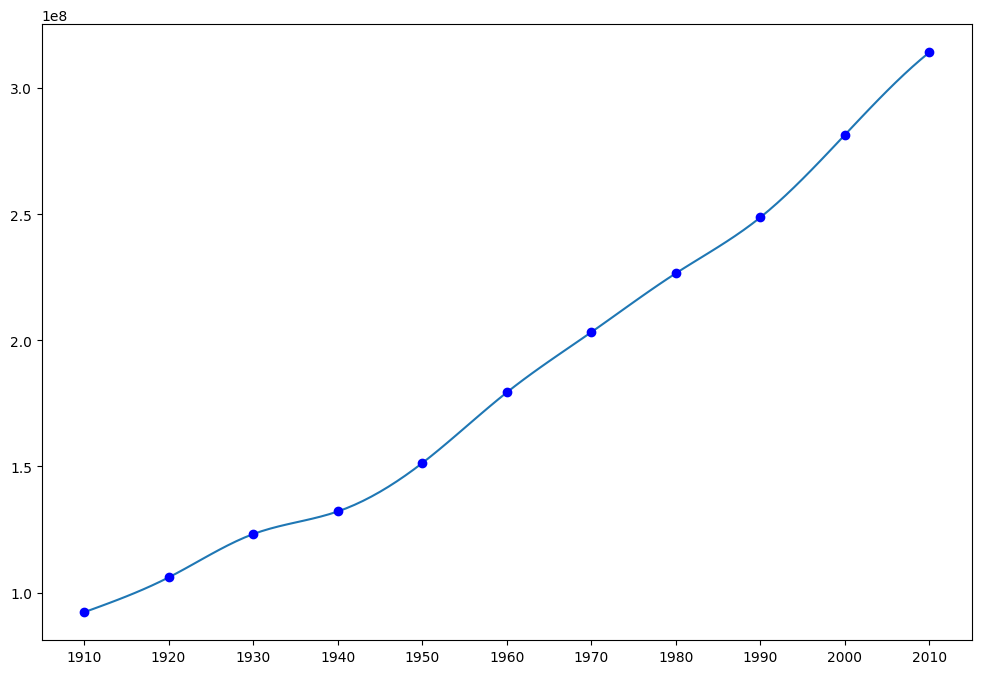

In [21]:
spline = compute_spline(years, values)

x_vals = np.arange(years[0], 2010 + 1, 1)
y_vals = [spline(y) for y in x_vals]

plt.figure(figsize=(12,8))
plt.plot(x_vals, y_vals)
plt.plot(np.append(years, 2010), np.append(values, spline(2010)), 'bo')
plt.xticks(np.append(years,2010))
plt.show()

### Определение значения численности населения в 2010-ом году

In [22]:
val_2010_sp = spline(2010)
print("Экстраполированное значение численности населения ", int(val_2010_sp))
val_2010_real = 308745538
print("Погрешность данной величины равна: ", 100*(val_2010_sp-val_2010_real)/val_2010_real, "%")

Экстраполированное значение численности населения  314133939
Погрешность данной величины равна:  1.745256315250781 %
